In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(graph, metric):
    plt.plot(graph.history[metric])
    plt.plot(graph.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [5]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print(encoded_string)
original_string = encoder.decode(encoded_string)
print(original_string)


[4025, 222, 6307, 2327, 4043, 2120, 7975]
Hello TensorFlow.


In [6]:
assert original_string == sample_string

In [7]:
for index in encoded_string:
    print('{} ---> {}'.format(index, encoder.decode([index])))

4025 ---> Hell
222 ---> o 
6307 ---> Ten
2327 ---> sor
4043 ---> Fl
2120 ---> ow
7975 ---> .


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [9]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

1. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors
2. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors
3. A recurrent neural network (RNN) processes sequence input by iterating through the elements
4. RNNs pass the outputs from one time step to their input—and then to the next.
5. The tf.keras.layers.Bidirectional wrapper can also be used with an RNN layer.
6. This propagates the input forward and backwards through the RNN layer and then concatenates the output.
7. This helps the RNN to learn long range dependencies.

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #32
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

SyntaxError: invalid syntax (<ipython-input-11-4b6f53ca8744>, line 6)

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [15]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1151s 3s/step - loss: 0.6700 - accuracy: 0.5271 - val_loss: 0.5009 - val_accuracy: 0.7349

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 304s 778ms/step - loss: 0.4770 - accuracy: 0.8416

In [17]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)

    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)

    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
    return predictions

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions_output = sample_predict(sample_text, pad=False)
print(predictions_output)

[[-0.15931088]]


In [19]:
sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions_output = sample_predict(sample_text, pad=False)
print(predictions_output)

[[-1.87987]]


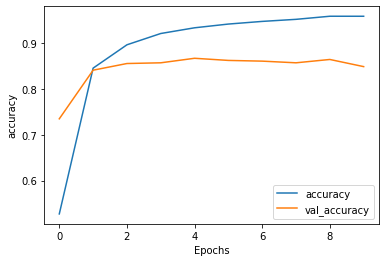

In [20]:
plot_graphs(history, 'accuracy')

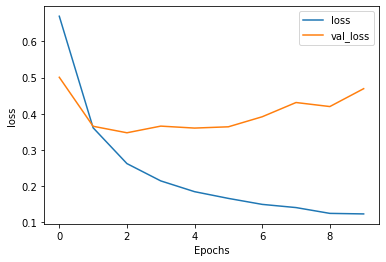

In [21]:
plot_graphs(history, 'loss')